# Experiment 3: Selection Bias and Batch Effects

In this experiment, we combine selection bias and batch effects. The AIRR data comes from 2 hospitals: `hospital1` that recruits mostly diseased and `hospital2` that recruits mostly healthy individuals. We explore three possible scenarios here:

1. the immune state signal is stronger than the influence of the experimental protocol used for AIRR-sequencing,

2. the immune state signal is weaker than the influence of the experimental protocol,

3. there is no connection between the immune state and AIRR: we will show that ML models will in this case learn only a spurious correlation.

Immune state is a binary variable and can have values `True` or `False` to indicate if an individual is diseased or healthy. AIRR is a set of sequences simulated based on the values of the immune state and the confounder for the given individual. Hospital is a binary variable (`hospital1` or `hospital2`). Each hospital has their own experimental protocol that influences the observed AIRR. The influence of the experimental protocol on AIRR is manifested via higher frequency of some k-mers in the sequenced AIRRs.

Steps for each scenario:

1. Simulate training and test dataset from a causal graph to include the variables as described above.

2. Train an ML model (here: logistic regression on repertoires represented by the k-mer frequencies) on the train set which has selection bias and assess its performance on the test set when there is no selection bias.

Software used: 

- DagSim for simulation of the causal graph; 
- immuneML v2.1 for implanting signal in AIRRs and for training and assessing machine learning classifiers; 
- OLGA for simulation of naive AIRRs

In [1]:
import os
import yaml
import dagsim.baseDS as ds
import numpy as np
from pathlib import Path
from util.repertoire_util import make_olga_repertoire, load_iml_repertoire, make_AIRR_dataset, make_dataset, setup_path
from util.implanting import make_immune_signal, make_repertoire_without_signal, make_repertoire_with_signal, make_exp_protocol_signal
from util.simulation import get_immune_state, get_hospital, get_exp_protocol, get_repertoire, get_selection
from immuneML.util.PathBuilder import PathBuilder
from immuneML.simulation.implants.Signal import Signal

In [2]:
setup_path("./experiment3") # remove results from the previous run

train_example_count = 200
test_example_count = 50

Removing experiment3...


## Scenario 1: immune state signal is stronger than the influence of experimental protocol

In [3]:
# define and build path, remove content if not empty

scenario1_path = setup_path("./experiment3/scenario1/")
scenario1_data_path = setup_path(scenario1_path / "data")

### Step 1: AIRR simulation from a causal graph

In [4]:
# define constants for the simulation

p_immune_state = 0.5 # parameter of binomial distribution for the immune state
p_hospital = 0.5 # parameter of binomial distribution for selecting between hospitals 1 and 2

sequence_count = 2000
immune_state_implanting_rate = 0.02
protocol_implanting_rate = 0.01

immune_state_signal = make_immune_signal()

In [5]:
immune_state_node = ds.Generic(name="immune_state", function=get_immune_state, arguments={"p": p_immune_state})

hospital_node = ds.Generic(name="hospital", function=get_hospital, arguments={"p": p_hospital})

experimental_protocol_node = ds.Generic(name="exp_protocol", function=get_exp_protocol, arguments={"hospital": hospital_node})

repertoire_node = ds.Generic(name="repertoire", function=get_repertoire, 
                             arguments={"immune_state": immune_state_node, "experimental_protocol": experimental_protocol_node,
                                        "path": scenario1_data_path / "train", "sequence_count": sequence_count, "immune_state_signal": immune_state_signal, 
                                        'immune_state_implanting_rate': immune_state_implanting_rate, "protocol_implanting_rate": protocol_implanting_rate})

selection_node = ds.Selection(name="S", function=get_selection, arguments={"hospital": hospital_node, "immune_state": immune_state_node})

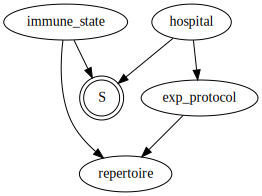

In [6]:
# make a causal graph using DagSim and show it graphically

graph = ds.Graph(name="graph_experiment_3_1", list_nodes=[immune_state_node, hospital_node, experimental_protocol_node, repertoire_node, selection_node])
graph.draw()

In [7]:
training_data_sc1 = graph.simulate(num_samples=train_example_count, 
                                   csv_name=str(scenario1_data_path / "train/study_cohort"))

# make an AIRR dataset from the generated repertoires to be used for training

train_dataset = make_dataset(repertoire_paths=training_data_sc1["repertoire"], path=scenario1_data_path / 'train', 
                             dataset_name="experiment3_sc1_train", 
                             signal_names=[immune_state_signal.id, experimental_protocol_node.name])

In [9]:
# make a test dataset

repertoire_node.additional_parameters['path'] = scenario1_data_path / 'test' # update result_path: to be removed with DagSim update

test_data = graph.simulate(num_samples=test_example_count, csv_name=str(scenario1_data_path / "test/test_cohort"), selection=False)

test_dataset = make_dataset(repertoire_paths=test_data["repertoire"], path=scenario1_data_path / 'test',
                            dataset_name="experiment3_sc1_test", signal_names=[immune_state_signal.id, experimental_protocol_node.name])


In [10]:
# merge datasets (but the distinction between train and test will be kept in the ML analysis part)

dataset = make_AIRR_dataset(train_dataset, test_dataset, scenario1_data_path / 'full_dataset')

### Step 2: Training an ML model

In [11]:
specs = {
    "definitions": {
        "datasets": {
            "dataset1": {
                "format": 'AIRR',
                "params": {
                    "path": str(scenario1_data_path / 'full_dataset'),
                    "metadata_file": str(scenario1_data_path / 'full_dataset/metadata.csv')
                }
            }
        },
        "encodings": {
            "kmer_frequency": {
                "KmerFrequency": {"k": 3}
            }
        },
        "ml_methods": {
            "logistic_regression": {
                "LogisticRegression": {
                    "penalty": "l1",
                    "C": [0.01, 0.1, 1, 10, 100],
                    "max_iter": 1500,
                    "show_warnings": False
                },
                "model_selection_cv": True,
                "model_selection_n_folds": 5
            }
        },
        "reports": {
            "motif_recovery_immune_state": { # to check how much coefficients overlap with the immune state signal that was implanted
                "MotifSeedRecovery": {
                    "implanted_motifs_per_label": {
                        "immune_state": {
                            "seeds": ["ADR", "ATS"],
                            "hamming_distance": True,
                            "gap_sizes": [0] # no gaps
                        }
                    }
                }
            },
            "motif_recovery_protocol": { # to check how much coefficients overlap with the immune state signal that was implanted
                "MotifSeedRecovery": {
                    "implanted_motifs_per_label": {
                        "immune_state": {
                            "seeds": ["ADR", "ATS"],
                            "hamming_distance": True,
                            "gap_sizes": [0] # no gaps
                        }
                    }
                }
            },
            "coefficients": {
                "Coefficients": { # show top 25 logistic regression coefficients and what k-mers they correspond to
                    "coefs_to_plot": ['n_largest'],
                    "n_largest": [25]
                }
            },
            "feature_comparison": {
                "FeatureComparison": {
                    "comparison_label": "immune_state",
                    "color_grouping_label": "experimental_protocol",
                    "show_error_bar": False,
                    "keep_fraction": 0.1
                }
            }
        }
    },
    "instructions": {
        'train_ml': {
            "type": "TrainMLModel",
            "assessment": { # ensure here that train and test dataset are fixed, as per simulation
                "split_strategy": "manual",
                "split_count": 1,
                "manual_config": {
                    "train_metadata_path": str(scenario1_data_path / "train/experiment3_sc1_train_metadata.csv"),
                    "test_metadata_path": str(scenario1_data_path / "test/experiment3_sc1_test_metadata.csv")
                },
                "reports": {
                    "models": ["coefficients", "motif_recovery_immune_state", "motif_recovery_protocol"],
                    "encoding": ["feature_comparison"]
                }
            },
            "selection": {
                "split_strategy": "random",
                "train_percentage": 0.7,
                "split_count": 1,
                "reports": {
                    "models": ["coefficients", "motif_recovery_immune_state", "motif_recovery_protocol"],
                    "encoding": ["feature_comparison"]
                }
            },
            "settings": [
                {"encoding": "kmer_frequency", "ml_method": "logistic_regression"}
            ],
            "dataset": "dataset1",
            "refit_optimal_model": False,
            "labels": ["immune_state"],
            "optimization_metric": "log_loss",
            "metrics": ['balanced_accuracy', 'auc']
        }
    }
}

scenario1_ml_result_path = setup_path("./experiment3/scenario1/ml_result/")
scenario1_specs_path = scenario1_ml_result_path / "specs.yaml"

with open(scenario1_specs_path, "w") as file:
    yaml.dump(specs, file)

In [12]:
# run immuneML with the specs file

from immuneML.app.ImmuneMLApp import ImmuneMLApp

scenario1_output_path = scenario1_ml_result_path / "result/"

app = ImmuneMLApp(specification_path = scenario1_specs_path, result_path = scenario1_output_path)
result = app.run()

print("The results are located under ./experiment3/scenario1/")

2021-11-14 15:12:53.635161: Setting temporary cache path to experiment3/scenario1/ml_result/result/cache
2021-11-14 15:12:53.635759: ImmuneML: parsing the specification...



/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/immuneML/util/ImportHelper.py:49: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  dataset = ImportHelper.import_repertoire_dataset(import_class, processed_params, dataset_name)


2021-11-14 15:13:36.805616: Full specification is available at experiment3/scenario1/ml_result/result/full_specs.yaml.

2021-11-14 15:13:36.806676: ImmuneML: starting the analysis...

2021-11-14 15:13:36.807186: Instruction 1/1 has started.
2021-11-14 15:13:36.896337: Training ML model: running outer CV loop: started split 1/1.

2021-11-14 15:13:36.954335: Hyperparameter optimization: running the inner loop of nested CV: selection for label immune_state (label 1 / 1).

2021-11-14 15:13:36.955724: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-11-14 15:13:36.956673: Encoding started...


2021-11-14 15:13:46.258415: Encoding finished.
2021-11-14 15:13:46.258843: ML model training started...


/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


2021-11-14 15:14:51.397317: ML model training finished.
2021-11-14 15:14:57.997252: Encoding started...


2021-11-14 15:15:03.031982: Encoding finished.
2021-11-14 15:15:07.596062: Completed hyperparameter setting kmer_frequency_logistic_regression.

2021-11-14 15:15:07.597620: Hyperparameter optimization: running the inner loop of nested CV: completed selection for label immune_state (label 1 / 1).

2021-11-14 15:15:07.598384: Training ML model: running the inner loop of nested CV: retrain models for label immune_state (label 1 / 1).

2021-11-14 15:15:07.599845: Evaluating hyperparameter setting: kmer_frequency_logistic_regression...
2021-11-14 15:15:07.601752: Encoding started...


2021-11-14 15:15:15.340894: Encoding finished.
2021-11-14 15:15:15.341349: ML model training started...


/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.

/Users/milenpa/PycharmProjects/CausalAIRR/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



2021-11-14 15:16:47.434199: ML model training finished.
2021-11-14 15:16:55.372366: Encoding started...
2021-11-14 15:17:00.016525: Encoding finished.
2021-11-14 15:17:04.239389: Completed hyperparameter setting kmer_frequency_logistic_regression.

2021-11-14 15:17:04.241293: Training ML model: running the inner loop of nested CV: completed retraining models for label immune_state (label 1 / 1).

2021-11-14 15:17:04.242173: Training ML model: running outer CV loop: finished split 1/1.

Performances (log_loss) -----------------------------------------------


Label: immune_state
Performance (log_loss) per assessment split:
Split 1: 0.2829830373641097
Average performance (log_loss): 0.2829830373641097
------------------------------
2021-11-14 15:17:04.611952: Instruction 1/1 has finished.
2021-11-14 15:17:04.624968: Generating HTML reports...
2021-11-14 15:17:04.987503: HTML reports are generated.
2021-11-14 15:17:05.023451: ImmuneML: finished analysis.

The results are located under ./e

In [35]:
from util.plotting import plot_validation_vs_test_performance

plot_validation_vs_test_performance(iml_result=result, result_path=scenario1_ml_result_path)

TypeError: unsupported operand type(s) for +: 'set' and 'list'

## Scenario 3: immune state does not influence the AIRR: learning spurious correlations

In [ ]:
# define and build path, remove content if not empty

scenario3_path = setup_path("./experiment3/scenario3/")

data_path = setup_path(scenario3_path / "data")

repertoire_node = ds.Generic(name="repertoire", function=get_repertoire,
                             arguments={"immune_state": False, "experimental_protocol": experimental_protocol_node,
                                        "path": data_path / "train", "sequence_count": sequence_count, 
                                        "immune_state_signal": immune_state_signal,
                                        'repertoire_implanting_rate': repertoire_implanting_rate})

In [ ]:
# make a causal graph using DagSim and show it graphically

graph = ds.Graph(name="graph_experiment_3_3", list_nodes=[index_node, immune_state_node, hospital_node, experimental_protocol_node, repertoire_node, selection_node])
graph.draw()

In [ ]:
# make a train dataset

training_data_sc1 = graph.simulate(num_samples=train_example_count, csv_name=str(data_path / "train/study_cohort"))

train_dataset = make_dataset(repertoires=training_data_sc1["repertoire"], path=data_path / 'train', 
                             dataset_name="experiment3_sc3_train",
                             signal_names=[immune_state_signal.id, experimental_protocol_node.name])

In [ ]:
# make a test dataset

repertoire_node.additional_parameters['path'] = data_path / 'test' # update result_path: to be removed with DagSim update

test_data = graph.simulate(num_samples=test_example_count, csv_name=str(data_path / "test/test_cohort"), selection=False)

test_dataset = make_dataset(repertoires=test_data["repertoire"], path=data_path / 'test',
                            dataset_name="experiment3_sc3_test", signal_names=[immune_state_signal.id, experimental_protocol_node.name])


In [ ]:
# merge datasets (but the distinction between train and test will be kept in the ML analysis part)

dataset = make_AIRR_dataset(train_dataset, test_dataset, data_path / 'full_dataset')